# THIS IS NOT RUNNING

# But is starting to do spatiall stacking/averaging




In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm

from shapely.geometry import Point, LineString, Polygon
import fiona

In [21]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [4]:
bed_gdf.head()

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700)
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300)
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100)
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600)
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100)


# Interpolation

1. split each line into three parts, 1) flat, 2) channel, 3) flat .
2. interpolate the two flat parts to have less points.
3. concatenate

### Split gdf into lines

In [22]:
ll = {} #a dictionary of geodataframes of radarlines over KIS2

for line in bed_gdf.line_name.unique().tolist():
    ll[line] = bed_gdf[(bed_gdf.line_name==line) & (bed_gdf.camp=='KIS2')].copy()

In [46]:
def add_distance_to_gdf(gdf):
    """
    Input: geodataframe
    Output: Adds columns 'dx' and 'distance_cum' and 'dDELAY' and 'dDELAYdx'
    """
    tmp_dfp = [Point.distance(gdf.geometry.iloc[i]) for i,Point in enumerate(gdf.geometry.iloc[1:])] #note the 1:, equivalent to i+1
    tmp_dfp[:0] = [0]
    gdf['dx'] = pd.Series(tmp_dfp) 
    gdf['distan_cum'] = gdf.dx.cumsum().copy()
    
    gdf['dDELAY'] = gdf.DELAY.diff()
        
    gdf['dDELAYdx'] = gdf.dDELAY.to_numpy()/gdf.dx.to_numpy()

In [48]:
for line_name, line_gdf in ll.items():
    add_distance_to_gdf(line_gdf)
    

In [49]:
ll['line7'].head()

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry,dx,distan_cum,dDELAY,dDELAYdx
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700),0.000000,0.000000,NaN,NaN
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300),1.843909,1.843909,0.0,0.0
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100),2.842534,4.686443,0.0,0.0
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600),3.264966,7.951409,0.0,0.0
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100),3.264966,11.216374,0.0,0.0


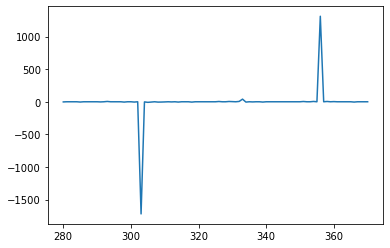

In [55]:
plt.plot(ll['line7'].dDELAYdx.loc[280:370])

In [54]:
#def split_into_three(gdf):
print(ll['line7'].dDELAYdx.idxmin(),ll['line7'].dDELAYdx.idxmax())
    
    

303 356


In [5]:
def stack_spatially(gdf,stack_distance=5):
    """
    stack traces to end with points every stack_distance appart ( in m)
    I.e. resample spatially.
    """

    bins = np.arange(-5,gdf.distan_cum.iloc[-1]+10,stack_distance)


    gdf['distance_bins'] = pd.cut(gdf.distan_cum, bins ,labels=(bins[:-1]+5)   )     #then average each bin see https://stackoverflow.com/questions/45273731/binning-column-with-python-pandas#45273750

            #now stack over the distance bins
        
    #indicies at the edges of distance bins     
    splitdistance_index = np.hstack([np.argwhere(gdf.distance_bins.diff().to_numpy() !=0 ).flatten(),-1])

    stacked_DELAY = np.zeros([len(splitdistance_index)-1,1])
    for i, index in enumerate(splitdistance_index[:-1]):
        stacked_DELAY[i,:] = np.mean( gdf.DELAY[index:splitdistance_index[i+1]],axis=0 )    
    ch0 = stacked_ch0

    gdf_out = gdf.iloc[splitdistance_index].copy()
    gdf_out.reset_index(drop=True,inplace=True)
    
    return gdf_out

In [ ]:
df.groupby('bin').mean()

df_ages['age_by_decade'] = pd.cut(x=df_ages['age'], bins=[20, 29, 39, 49], labels=['20s', '30s', '40s'])

In [57]:
pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3)

[(0.994, 3.0], (5.0, 7.0], (3.0, 5.0], (3.0, 5.0], (5.0, 7.0], (0.994, 3.0]]
Categories (3, interval[float64]): [(0.994, 3.0] < (3.0, 5.0] < (5.0, 7.0]]

In [110]:
def bin_mean(gdf,bin_size = 20):
    L= -(- gdf.distan_cum.iloc[-1] // bin_size)*bin_size #length of line

    ir = pd.interval_range(0,L,freq=bin_size)

    bins = pd.cut( gdf.distan_cum , bins=ir ,label)

    return gdf.groupby(bins).mean()

    


In [103]:
gdf_oo = bin_mean(ll['line7'])

# Take a look at differences in different binning

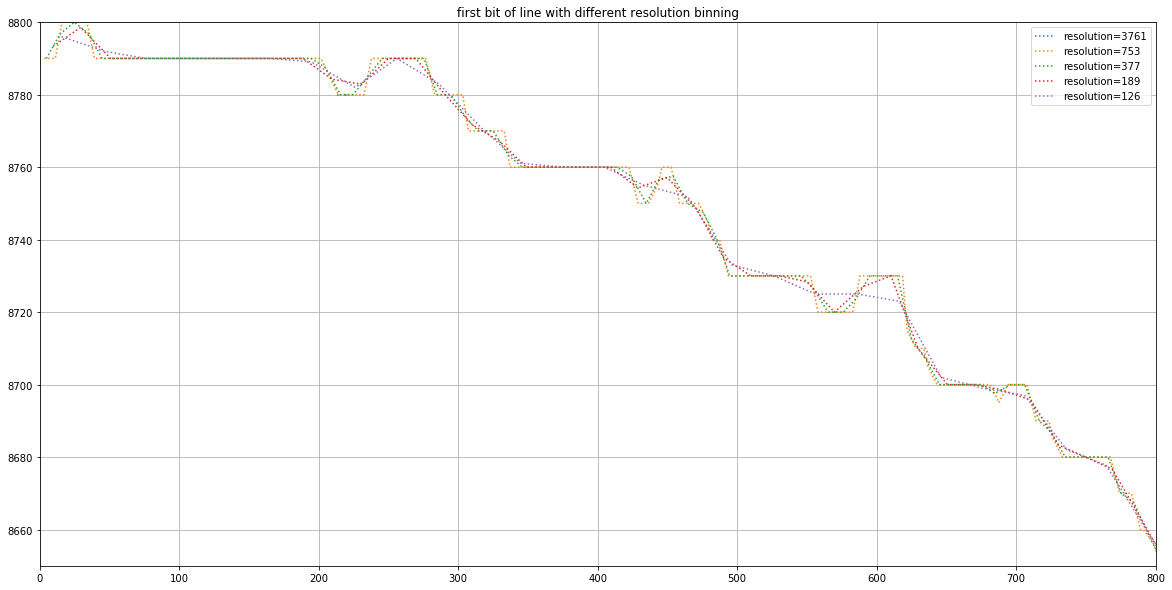

In [136]:
plt.figure(figsize=(20,10))
for i in [1,5,10,20,30]:
    gdf_out = bin_mean( ll['line7'],bin_size = i )
    plt.plot(gdf_out.distan_cum,gdf_out.DELAY,':',label='resolution='+str(gdf_out.shape[0]))
plt.legend()
plt.xlim([0,800])
plt.ylim([8650,8800])
plt.grid()
plt.title('first bit of line with different resolution binning')
plt.show()

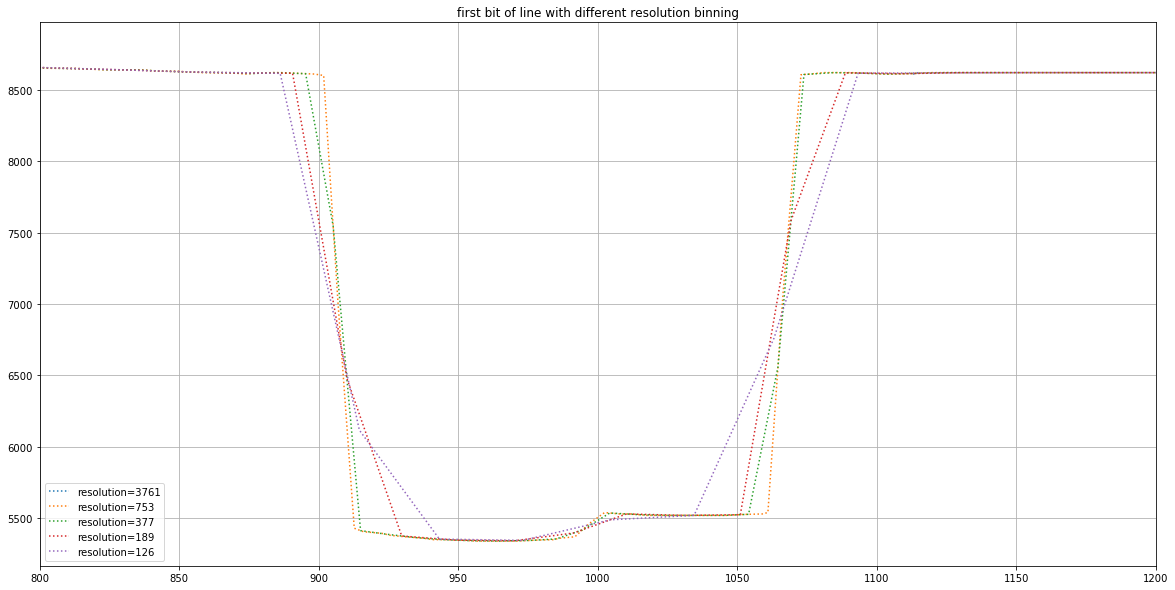

In [137]:
plt.figure(figsize=(20,10))
for i in [1,5,10,20,30]:
    gdf_out = bin_mean( ll['line7'],bin_size = i )
    plt.plot(gdf_out.distan_cum,gdf_out.DELAY,':',label='resolution='+str(gdf_out.shape[0]))
plt.legend()
plt.xlim([800,1200])
plt.grid()
plt.title('first bit of line with different resolution binning')
plt.show()

In [109]:
gdf_out = bin_mean( ll['line7'],bin_size = i )

,x,y,DELAY,SEQnum,dx,distan_cum,dDELAY,dDELAYdx
distan_cum,,,,,,,,
"(0.0, 20.0]",-381558.450000,-725992.316667,8793.333333,1.0,2.817026,9.609757,1.666667,0.433816
"(20.0, 40.0]",-381545.657143,-725977.200000,8798.571429,1.0,3.201571,29.415128,-1.428571,-0.315058
"(40.0, 60.0]",-381531.814286,-725960.857143,8790.000000,1.0,2.881095,50.836085,0.000000,0.000000
"(60.0, 80.0]",-381519.400000,-725945.983333,8790.000000,1.0,3.183104,70.215893,0.000000,0.000000
"(80.0, 100.0]",-381507.128571,-725931.042857,8790.000000,1.0,2.950236,89.557881,0.000000,0.000000
...,...,...,...,...,...,...,...,...
"(3680.0, 3700.0]",-379045.600000,-723313.300000,8501.666667,1.0,3.371002,3691.390073,-1.666667,-0.785674
"(3700.0, 3720.0]",-379031.800000,-723299.728571,8500.000000,1.0,2.778665,3710.748380,0.000000,0.000000
"(3720.0, 3740.0]",-379017.750000,-723286.050000,8491.666667,1.0,2.934970,3730.359714,-1.666667,-0.693242


In [6]:
line7 = bed_gdf.query("line_name == 'line7'")

In [7]:
add_distance_to_gdf(line7)

/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/home/whitefar/miniconda3/envs/remote_sensing/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
line7

,CDP,x,y,DELAY,line_name,SEQnum,camp,geometry,dx,distan_cum
0,100,-381564.6,-725999.7,8790,line7,1,KIS2,POINT (-381564.600 -725999.700),0.000000,0.000000
1,101,-381563.4,-725998.3,8790,line7,1,KIS2,POINT (-381563.400 -725998.300),1.843909,1.843909
2,102,-381561.6,-725996.1,8790,line7,1,KIS2,POINT (-381561.600 -725996.100),2.842534,4.686443
3,103,-381559.5,-725993.6,8790,line7,1,KIS2,POINT (-381559.500 -725993.600),3.264966,7.951409
4,104,-381557.4,-725991.1,8790,line7,1,KIS2,POINT (-381557.400 -725991.100),3.264966,11.216374
...,...,...,...,...,...,...,...,...,...,...
1250,1350,-379003.4,-723272.2,8490,line7,1,KIS2,POINT (-379003.400 -723272.200),4.386342,3750.305178
1251,1351,-379001.8,-723270.5,8490,line7,1,KIS2,POINT (-379001.800 -723270.500),2.334524,3752.639701
1252,1352,-379000.2,-723269.0,8490,line7,1,KIS2,POINT (-379000.200 -723269.000),2.193171,3754.832872
1253,1353,-378997.3,-723266.3,8490,line7,1,KIS2,POINT (-378997.300 -723266.300),3.962323,3758.795195


In [ ]:
lines_gdf.set_index('line_names',inplace=True)
lines_gdf.head()

In [ ]:


for line0 in lines_gdf.index.tolist():
    for line1 in lines_gdf.index.tolist():
        if line0.intersects(line1):
            isect_pnt = first.intersection(second)

In [ ]:
lines_gdf.index.tolist()